<a href="https://colab.research.google.com/github/marcellosusanto11/Tugas-Deep-Learning/blob/master/predict_bbca_stock/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Set working directory
%cd drive/My\ Drive/Colab\ Notebooks/Tugas\ Deep\ Learning\ II

/content/drive/My Drive/Colab Notebooks/Tugas Deep Learning II


In [0]:
# Install package
!pip install torch

In [0]:
# Setting general package
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import copy
%matplotlib inline

from matplotlib.pylab import rcParams
# For every plotting cell use this
# grid = gridspec.GridSpec(n_row,n_col)
# ax = plt.subplot(grid[i])
# fig, axes = plt.subplots()
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:.4f}'.format

## Function
Every cell in this block containing the class and function use in this notebook

In [0]:
# Function to give quick general information about the dataset
def dataset_summary(df) :
  '''
  Give quick feneral information about the dataset such as dtpes, missing values, and unique values

  Args :
   - df (pd.DataFrame) : Dataset

  Return :
   - summary_df (pd.DataFrame) : Contain general information
  '''
  
  # Make summary dataframe
  summary_df = pd.DataFrame()

  # Input the characteristic of the dataset
  summary_df['Var'] = df.columns
  summary_df['Dtypes'] = df.dtypes.values
  summary_df['Total Missing'] = df.isnull().sum().values
  summary_df['Missing%'] = summary_df['Total Missing'] / len(df) * 100
  summary_df['Total Unique'] = df.nunique().values
  summary_df['Unique%'] = summary_df['Total Unique'] / len(df) * 100

  # Dataset dimension
  print('Dataset dimension :',df.shape)

  return summary_df


In [0]:
# Function to do a minmaxscaler define by the EDA
def modified_minmaxscaler(df, list_var) :
  '''
  MinMaxScaler defined using the EDA
  used this if you used Sigmoid function as the output layer activation function
  max = 1.1 * Maximum value of `High`
  min = 0.9 * Minimum value of `Close`

  Args :
   - df (pd.DataFrame) : Dataframe to scale
   - list_var (list) : Variable to scale

  Output :
   - result_df (pd.DataFrame) : Scaled dataframe
   - f_inv_scale (lambda func) : Function to redo the minmaxscaler
  '''

  # Initiate dataframe
  result_df = df.copy()

  # Make the scaler
  val_max = 1.1 * np.max(result_df['High'])
  val_min = 0.9 * np.min(result_df['Close'])
  f_scale = lambda x : (x - val_min) / (val_max - val_min)
  f_inv_scale = lambda x : x * (val_max - val_min) + val_min

  # Scale the dataframe
  for var in list_var :
    result_df[var] = f_scale(result_df[var])

  return result_df, f_inv_scale

In [0]:
# Function to make the time steps data
def preproc(df, step, list_var) :
  '''
  Make the time steps normalized dataset and split it into train and test

  Args :
   - df (pd.DataFrame) : Dataset
   - step (int) : Time steps

  Outptut
   - train_df (pd.DataFrame) : Dataset for model training
   - test_df (pd.DataFrame) : Dataset for model evaluation
  '''

  # Initialize the dataset
  dummy_df = df.copy()

  # Make the timestep data
  add_var = []
  for i in range(step,0,-1) :

    for var in list_var :
      
      # Make the shifted variable
      dummy_df[var+' Shift'+str(i)] = dummy_df[var].shift(i)
      add_var.append(var+' Shift'+str(i))

    # Make the shifted response
    dummy_df['Close Shift'+str(i-1)] = dummy_df['Close'].shift(i-1)
    add_var.append('Close Shift'+str(i-1))

  # Filter the unnecessary data
  dummy_df = dummy_df[add_var]
  dummy_df = dummy_df.iloc[step:, :]

  # Split data again
  train_df = dummy_df.iloc[:-150, :]
  test_df = dummy_df.iloc[-150:, :]

  return train_df, test_df


In [0]:
## Activation Function

# Sigmoid
def sigmoid(s) :
  return 1 / (1 + torch.exp(-s))

# Derivate of Sigmoid
def der_sigmoid(s) :
  return s * (1 - s)

# Derivative of MSE based on Sigmoid
def der_sigmoid_mse(s, y) :
  return (s - y) * s * (1 - s)

# Tanh
def tanh(s) :
  return torch.tanh(s)

# Derivate of Tanh
def der_tanh(s) :
  return 1 - s**2

# Identity
def identity(s) :
  return s

# Derivative of MSE based on Identity
def der_identity_mse(s, y) :
  return s - y

In [0]:
# RNN Class
class RecurrentNeuralNetwork() :
  
  # Variable initiation
  def __init__(self, data, hl_act, ol_act, der_hl_act, der_ol_act, Ni, Nh, No, step, reg=None, n_layer=1, alpha=1, l=0):

    # Initiate seed
    # NIM : 10116017
    torch.manual_seed(10116017)

    # Variable to modify the ANN
    self.data = torch.from_numpy(data).float().cuda()
    self.step = step
    self.alpha = alpha #Learning rate
    self.l = l
    self.n_layer = n_layer
    self.reg = reg

    # Define activation function used in this model
    self.hl_act = hl_act
    self.ol_act = ol_act
    self.der_hl_act = der_hl_act
    self.der_ol_act = der_ol_act

    # Define dimension
    self.Ni = Ni
    self.Nh = Nh
    self.No = No

    # Initiate weigth and derivative
    self.W0    = torch.randn(self.Ni, self.Nh).cuda()
    self.b0    = torch.randn(self.No, self.Nh).cuda()
    self.W1    = torch.randn(self.Nh, self.No).cuda()
    self.b1    = torch.randn(self.No, self.No).cuda()
    self.Wh    = torch.randn(self.Nh, self.Nh).cuda()

    self.dW0   = torch.zeros(self.Ni, self.Nh).cuda()
    self.db0   = torch.zeros(self.No, self.Nh).cuda()
    self.dW1   = torch.zeros(self.Nh, self.No).cuda()
    self.db1   = torch.zeros(self.No, self.No).cuda()
    self.dWh   = torch.zeros(self.Nh, self.Nh).cuda()

  # Train
  def train(self) :

    for row in range(len(self.data)) :

      # Initiate list to save the HL value and derivative of output
      self.dummy_A1 = [torch.zeros(self.No, self.Nh).cuda()]
      self.list_X = []
      list_delta2 = []

      # Forward Propagation
      for s in range(self.step) :

        # Take the sample predictor and response
        X = self.data[row, s*(self.Ni+1) : (s+1)*(self.Ni+1) - 1].view(-1,1)
        self.list_X.append(copy.deepcopy(X))
        y = self.data[row, (s+1)*(self.Ni+1) - 1].view(-1,1)

        # Input to Hidden 
        Z1 = torch.mm(X.T, self.W0) + torch.mm(self.dummy_A1[-1], self.Wh) + self.b0
        A1 = self.hl_act(Z1)
        self.dummy_A1.append(copy.deepcopy(A1))

        # Hidden to Output
        Z2 = torch.mm(A1, self.W1) + self.b1
        A2 = self.ol_act(Z2)

        # Calculate error
        e = self.der_ol_act(A2, y)
        list_delta2.append(e/self.step)

      # Backward Propagation
      next_delta1 = torch.zeros(self.No, self.Nh).cuda()
      for s in range(1,self.step+1) :

        # Take the sample predictor and the recurrent neuron
        X = self.list_X[-s]
        A1 = self.dummy_A1[-s]
        prev_A1 = self.dummy_A1[-s-1]

        # Calculate the derivative
        delta2 = list_delta2[-s]
        delta1 = (torch.mm(next_delta1, self.Wh.T) + torch.mm(delta2, self.W1.T)) * self.der_hl_act(A1)
        next_delta1 = delta1

        # Update the delta of weight and bias
        if self.reg == 'l1' :
          self.dW1   += torch.mm(A1.T, delta2) + self.l
          self.db1   += torch.sum(delta2, axis = 0, keepdims = True)
          self.dW0   += torch.mm(X, delta1) +  self.l
          self.db0   += torch.sum(delta1, axis = 0, keepdims = True)
          self.dWh   += torch.mm(prev_A1.T, delta1) + self.l

        elif self.reg == 'l2' :
          self.dW1   += torch.mm(A1.T, delta2) + (self.l * torch.abs(self.W1))
          self.db1   += torch.sum(delta2, axis = 0, keepdims = True)
          self.dW0   += torch.mm(X, delta1) + (self.l * torch.abs(self.W0))
          self.db0   += torch.sum(delta1, axis = 0, keepdims = True)
          self.dWh   += torch.mm(prev_A1.T, delta1) + (self.l * torch.abs(self.Wh))

        else :
          self.dW1   += torch.mm(A1.T, delta2)
          self.db1   += torch.sum(delta2, axis = 0, keepdims = True)
          self.dW0   += torch.mm(X, delta1)
          self.db0   += torch.sum(delta1, axis = 0, keepdims = True)
          self.dWh   += torch.mm(prev_A1.T, delta1)


      # Update the weight and bias
      self.W1    -= self.alpha * self.dW1
      self.b1    -= self.alpha * self.db1
      self.W0    -= self.alpha * self.dW0 
      self.b0    -= self.alpha * self.db0
      self.Wh    -= self.alpha * self.dWh

      # Reset the delta
      self.dW1   *= 0
      self.db1   *= 0
      self.dW0   *= 0
      self.db0   *= 0
      self.dWh   *= 0

  # Predict
  def predict(self, data_predict) :

    # Initiate predictor
    data_predict = torch.from_numpy(data_predict).float().cuda()
    list_predict = []

    # Iteration to predict
    for row in range(len(data_predict)) :

      self.dummy_A1_predict = [torch.zeros(self.No, self.Nh).cuda()]

      # Forward Propagation
      for s in range(self.step) :

        # Take the sample predictor and response
        X = data_predict[row, s*(self.Ni+1) : (s+1)*(self.Ni+1) - 1].view(-1,1)
        y = data_predict[row, (s+1)*(self.Ni+1) - 1].view(-1,1)

        # Input to Hidden 
        Z1 = torch.mm(X.T, self.W0) + torch.mm(self.dummy_A1[-1], self.Wh) + self.b0
        A1 = self.hl_act(Z1)
        self.dummy_A1_predict.append(copy.deepcopy(A1))

        # Hidden to Output
        Z2 = torch.mm(A1, self.W1) + self.b1
        A2 = self.ol_act(Z2)
      
      # Save the prediction
      list_predict.append(A2.cpu().numpy()[0][0])

    return list_predict

In [0]:
# Function to compile everything
# Including the viz
def go_rnn(rnn, train, test, ax, title, iter) :

  # Start time
  from datetime import datetime
  tic = datetime.now()

  # Define list to store MAE from each epoch
  list_train_mae = []
  list_test_mae = []
  list_epochs = []

  # Iterate to training
  for i in range(epochs):

    # Forward and backward propagation
    rnn.train()

    # Caclculate accuracy for each iter epoch
    if i%iter == 0:
      from sklearn.metrics import mean_absolute_error

      # Calculate train MAE
      predict_train = rnn.predict(train.values)
      mae_train  = mean_absolute_error(train['Close Shift0'], predict_train)

      # Calculate test MAE
      predict_test = rnn.predict(test.values)
      mae_test = mean_absolute_error(test['Close Shift0'], predict_test)

      # Print the output
      print("Iterasi ke :", i,'||','MAE Train :',mae_train,'||','MAE Test :',mae_test)
      list_train_mae.append(mae_train)
      list_test_mae.append(mae_test)
      list_epochs.append(i)

  # End time
  toc = datetime.now()

  # Total time needed to modelling
  print ("Waktu yang diperlukan:", toc-tic)
  print('')

  # Plotting
  ax.plot(list_epochs, list_train_mae, 'o-', label='Train', color='#0099e5')
  ax.plot(list_epochs, list_test_mae, 'o-', label='Test', color='#ff4c4c')
  ax.set_title(title, fontsize=15, fontname='Monospace', fontweight="bold")
  ax.set_xlabel('Epochs', fontsize=15)
  ax.set_ylabel('MAE', fontsize=15)
  ax.legend() ;

  return predict_train, predict_test, list_epochs

## Data Understanding

In [0]:
# Load dataset
df_bbca = pd.read_csv('BBCA.JK.csv')

In [0]:
# Overview dataset
df_bbca.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,13175.0000,13425.0000,13150.0000,13225.0000,12516.0645,15495900
1,2016-01-05,13200.0000,13550.0000,13200.0000,13375.0000,12658.0225,19321800
2,2016-01-06,13325.0000,13500.0000,13200.0000,13200.0000,12492.4053,21074000
3,2016-01-07,13100.0000,13150.0000,13000.0000,13000.0000,12303.1270,29349300
4,2016-01-08,12950.0000,13100.0000,12950.0000,13000.0000,12303.1270,25164000


In [0]:
# Change `date` to datetime
df_bbca['Date'] = pd.to_datetime(df_bbca['Date'])

In [0]:
# Summary of the dataset
dataset_summary(df_bbca)

Dataset dimension : (1019, 7)


,Var,Dtypes,Total Missing,Missing%,Total Unique,Unique%
0,Date,datetime64[ns],0,0.0000,1019,100.0000
1,Open,float64,0,0.0000,436,42.7870
2,High,float64,0,0.0000,464,45.5348
3,Low,float64,0,0.0000,461,45.2404
4,Close,float64,0,0.0000,441,43.2777
5,Adj Close,float64,0,0.0000,526,51.6192
6,Volume,int64,0,0.0000,952,93.4249


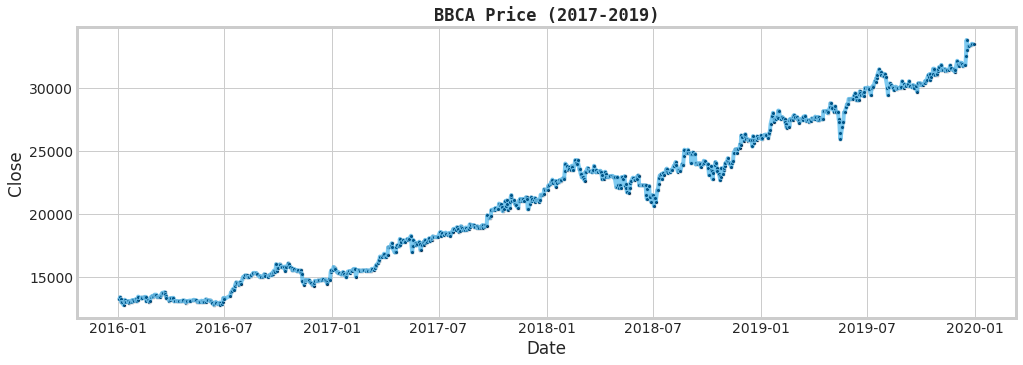

In [0]:
# Plot price change within time
rcParams['figure.figsize'] = [15,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Plot
sns.lineplot(data=df_bbca, x='Date', y='Close' , color='#0099e5', alpha=0.5)
sns.scatterplot(data=df_bbca, x='Date', y='Close' , color='#00112c', s=15)
plt.title('BBCA Price (2017-2019)', fontsize=17, fontname='Monospace', fontweight="bold") ;

We can see from the above lineplot that BBCA have an uptrend from 2016 to 2019 so we can conclude that BBCA are a great stock for long investment. Next we will see the descriptive statistics of the variable that will be used in the modelling

In [0]:
# Descriptive Statistics
df_bbca[['Open','High','Low','Close']].describe()

,Open,High,Low,Close
count,1019.0000,1019.0000,1019.0000,1019.0000
mean,21384.1511,21546.0255,21217.1001,21389.5976
std,5898.2939,5929.9996,5857.2087,5901.4754
min,12650.0000,12825.0000,12625.0000,12750.0000
25%,15500.0000,15600.0000,15400.0000,15500.0000
50%,21525.0000,21950.0000,21400.0000,21650.0000
75%,26087.5000,26300.0000,25900.0000,26200.0000
max,33500.0000,34000.0000,33350.0000,33775.0000


From the descriptive statistics we get :
- There are no significant difference between the mean of `Open` and `Close` so we can conclude that BBCA are a stable stock
- Difference between the mean of `High` and `Low` is around 300, so that is the maximum profit one can get each day averagely


In [0]:
# How many time the closing price differ from the opening price the next day
dummy_df = df_bbca.copy()
dummy_df['Shifted Close'] = dummy_df['Close'].shift(1).fillna(0)
dummy_df = dummy_df.iloc[1:,:]

yes = sum(dummy_df['Open'] == dummy_df['Shifted Close'])
print('Percentage of the data with difference closing and opening price :',yes/len(dummy_df)*100)

diff_df = dummy_df[dummy_df['Open'] != dummy_df['Shifted Close']]
diff = np.mean(np.abs(dummy_df['Open'] - dummy_df['Shifted Close']))
print('MAE of the difference :',diff)

Percentage of the data with difference closing and opening price : 24.656188605108053
MAE of the difference : 113.31041257367387


So 24% of the data have a differences between te closing and opening price. The average difference is about 113, quite a small number so the data are quite stable to model

## Modelling

#### Model 1
Using sigmoid as the output layer activation function

In [0]:
# Preprocesseing the dataset
list_var = ['Open', 'High', 'Low', 'Close']
dummy_df, inv_scaler = modified_minmaxscaler(df_bbca, list_var)

In [0]:
# Overview of the modelling data
list_var = ['Open', 'High', 'Low', 'Close']
step = 3
df_train, df_test = preproc(dummy_df, step, list_var)
df_train.head()

,Open Shift3,High Shift3,Low Shift3,Close Shift3,Close Shift2,Open Shift2,High Shift2,Low Shift2,Close Shift2,Close Shift1,Open Shift1,High Shift1,Low Shift1,Close Shift1,Close Shift0
3,0.0656,0.0752,0.0646,0.0675,0.0733,0.0665,0.0800,0.0665,0.0733,0.0665,0.0714,0.0781,0.0665,0.0665,0.0588
4,0.0665,0.0800,0.0665,0.0733,0.0665,0.0714,0.0781,0.0665,0.0665,0.0588,0.0627,0.0646,0.0588,0.0588,0.0588
5,0.0714,0.0781,0.0665,0.0665,0.0588,0.0627,0.0646,0.0588,0.0588,0.0588,0.0569,0.0627,0.0569,0.0588,0.0492
6,0.0627,0.0646,0.0588,0.0588,0.0588,0.0569,0.0627,0.0569,0.0588,0.0492,0.0569,0.0579,0.0492,0.0492,0.0627
7,0.0569,0.0627,0.0569,0.0588,0.0492,0.0569,0.0579,0.0492,0.0492,0.0627,0.0550,0.0675,0.0550,0.0627,0.0656


Iterasi ke : 0 || MAE Train : 0.38691167232549784 || MAE Test : 0.11300685407225629
Iterasi ke : 10 || MAE Train : 0.18268219253609178 || MAE Test : 0.05973331850274739
Iterasi ke : 20 || MAE Train : 0.12107840450400419 || MAE Test : 0.044876039837840574
Iterasi ke : 30 || MAE Train : 0.10405915516038045 || MAE Test : 0.04102136414750754
Iterasi ke : 40 || MAE Train : 0.10211806339993934 || MAE Test : 0.04074038665994345
Iterasi ke : 50 || MAE Train : 0.10505398286219408 || MAE Test : 0.04166778128846823
Iterasi ke : 60 || MAE Train : 0.1092782208825965 || MAE Test : 0.04294704240068137
Iterasi ke : 70 || MAE Train : 0.11355294791059933 || MAE Test : 0.044229328647299004
Iterasi ke : 80 || MAE Train : 0.11748939594160097 || MAE Test : 0.0453795743138029
Iterasi ke : 90 || MAE Train : 0.12102185997121334 || MAE Test : 0.04637174727026957
Waktu yang diperlukan: 0:05:23.128124



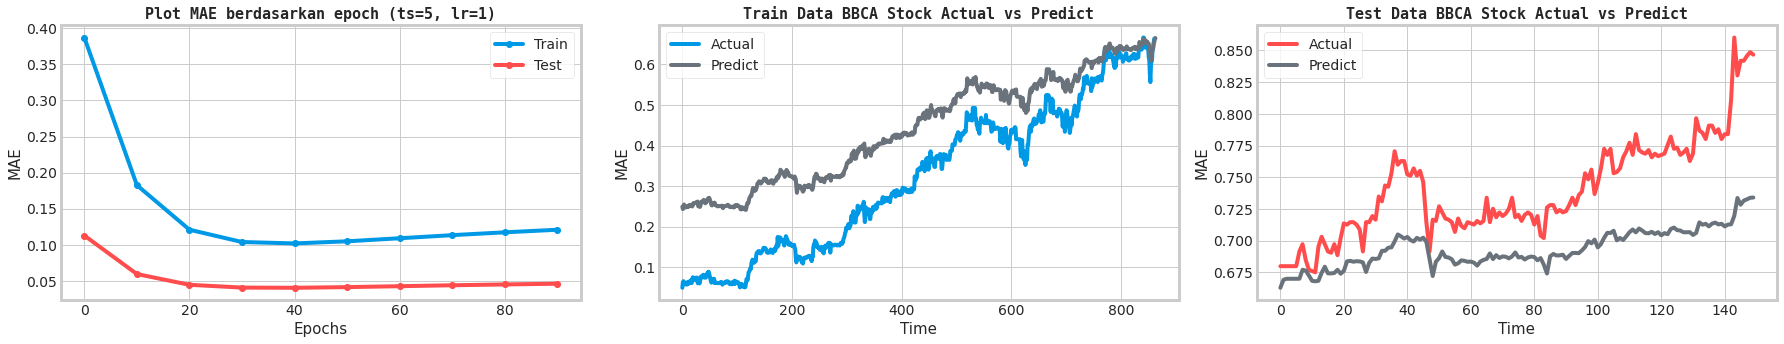

In [0]:
import torch

# Plot setting
rcParams['figure.figsize'] = [25,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Timesteps modification
list_ts = [5]

# Learning rate modification
list_lr = [0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5]
list_lr_2 = [0.3]

# For subplot
grid = gridspec.GridSpec(len(list_ts), 3)
list_df = []

for j,mod in enumerate(list_ts) :

  # Preprocessing dataset
  step = mod
  df_train, df_test = preproc(dummy_df, step, list_var)

  # Define variable and model parameter
  act_func_hidden_layer = sigmoid
  act_func_output_layer = sigmoid
  der_act_func_hidden_layer = der_sigmoid
  der_act_func_output_layer = der_sigmoid_mse
  Ni = len(list_var) # Input
  Nh = 16 # Total neuron in Hidden Layer
  No = 1 # Output
  alpha = 1
  reg = 'None'
  l = 0.00001 # Reg coefficient

  epochs = 100
  ax = plt.subplot(grid[j*3])
  ax_title = 'Plot MAE berdasarkan epoch (ts=' +  str(step) + ', lr=' + str(alpha) + ')'

  # Modelling
  rnn_model1 = RecurrentNeuralNetwork(data = df_train.values
                              ,hl_act = act_func_hidden_layer
                              ,ol_act = act_func_output_layer
                              ,der_hl_act = der_act_func_hidden_layer
                              ,der_ol_act = der_act_func_output_layer
                              ,Ni=Ni, Nh=Nh, No=No, reg=reg
                              ,step=step, alpha=alpha, l=l)

  # Go
  train_mae, test_mae, epo = go_rnn(rnn_model1, df_train, df_test, ax, ax_title, 10)

  # Plot the train prediction
  ax1 = plt.subplot(grid[(j*3)+1])
  ax1.plot(range(len(train_mae)), df_train['Close Shift0'], label='Actual', color='#0099e5')
  ax1.plot(range(len(train_mae)), train_mae, label='Predict', color='#6a737b')
  ax1.set_title('Train Data BBCA Stock Actual vs Predict', fontsize=15, fontname='Monospace', fontweight="bold")
  ax1.set_xlabel('Time', fontsize=15)
  ax1.set_ylabel('MAE', fontsize=15)
  ax1.legend() ;

  # Plot the test prediction
  ax1 = plt.subplot(grid[(j*3)+2])
  ax1.plot(range(len(test_mae)), df_test['Close Shift0'], label='Actual', color='#ff4c4c')
  ax1.plot(range(len(test_mae)), test_mae, label='Predict', color='#6a737b')
  ax1.set_title('Test Data BBCA Stock Actual vs Predict', fontsize=15, fontname='Monospace', fontweight="bold")
  ax1.set_xlabel('Time', fontsize=15)
  ax1.set_ylabel('MAE', fontsize=15)
  ax1.legend() ;

  plt.tight_layout()

In [0]:
# Convert prediction to stock value
result_df = df_test[['Close Shift0']]
result_df['Close Shift0'] = inv_scaler(result_df['Close Shift0'])

pred = np.array(rnn_model1.predict(df_test.values))
result_df['predict'] = inv_scaler(pred)

result_df.head(10)

,Close Shift0,predict
869,29100.0000,28654.0781
870,29100.0000,28818.2363
871,29100.0000,28834.6230
872,29100.0000,28834.6230
873,29100.0000,28834.6230
874,29100.0000,28834.6230
875,29400.0000,28834.6230
876,29550.0000,29014.5820
877,29225.0000,28999.0059
878,29025.0000,28900.3418


#### Model 2
Don't use activation function in output layer

In [0]:
# Preprocesseing the dataset
list_var = ['Open', 'High', 'Low', 'Close']
dummy_df, inv_scaler = modified_minmaxscaler(df_bbca, list_var)

Iterasi ke : 0 || MAE Train : 0.3382947573356394 || MAE Test : 0.07861238401635823
Iterasi ke : 50 || MAE Train : 0.19696940971742194 || MAE Test : 0.012144684034005426
Iterasi ke : 100 || MAE Train : 0.13437450330652162 || MAE Test : 0.025045465959762314
Iterasi ke : 150 || MAE Train : 0.12759684970123877 || MAE Test : 0.02389839920764643
Iterasi ke : 200 || MAE Train : 0.12074151836359476 || MAE Test : 0.022530885212140164
Iterasi ke : 250 || MAE Train : 0.11412648936190957 || MAE Test : 0.020885395222022887
Iterasi ke : 300 || MAE Train : 0.10786073002605022 || MAE Test : 0.019018335333210762
Iterasi ke : 350 || MAE Train : 0.1020587223550603 || MAE Test : 0.016968862012205925
Iterasi ke : 400 || MAE Train : 0.09681063482776094 || MAE Test : 0.014830489262857079
Iterasi ke : 450 || MAE Train : 0.09216911392268126 || MAE Test : 0.012673633790253757
Waktu yang diperlukan: 0:21:59.345558



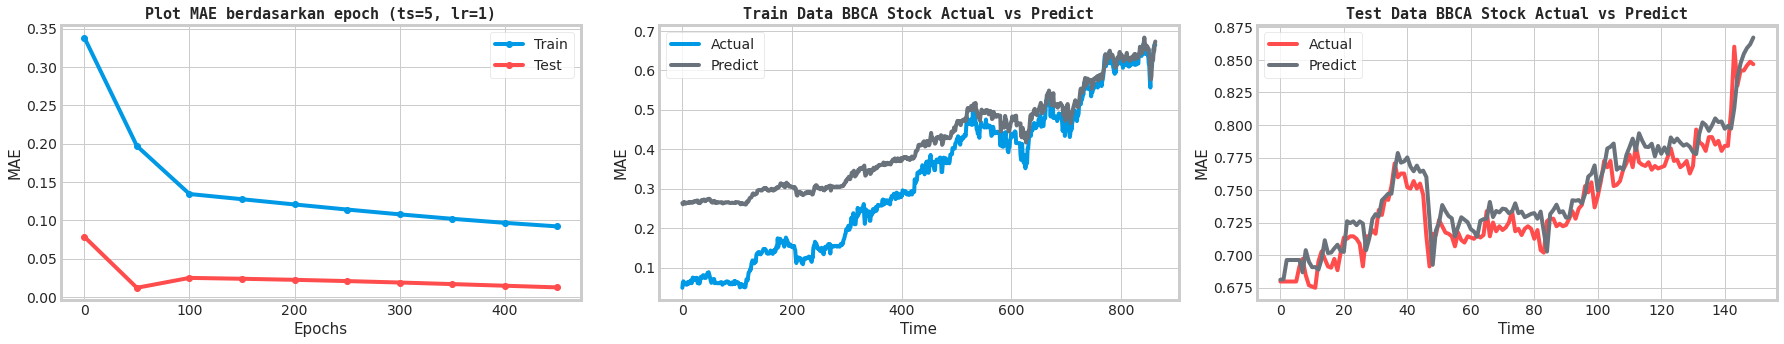

In [0]:
import torch

# Plot setting
rcParams['figure.figsize'] = [25,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Timesteps modification
list_ts = [5]

# Learning rate modification
list_lr = [0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5]
list_lr_2 = [0.3]

# For subplot
grid = gridspec.GridSpec(len(list_ts), 3)
list_df = []

for j,mod in enumerate(list_ts) :

  # Preprocessing dataset
  step = mod
  df_train, df_test = preproc(dummy_df, step, list_var)

  # Define variable and model parameter
  act_func_hidden_layer = sigmoid
  act_func_output_layer = identity
  der_act_func_hidden_layer = der_sigmoid
  der_act_func_output_layer = der_identity_mse
  Ni = len(list_var) # Input
  Nh = 16 # Total neuron in Hidden Layer
  No = 1 # Output
  alpha = 1
  reg = 'None'
  l = 0.00001 # Reg coefficient

  epochs = 500
  ax = plt.subplot(grid[j*3])
  ax_title = 'Plot MAE berdasarkan epoch (ts=' +  str(step) + ', lr=' + str(alpha) + ')'

  # Modelling
  rnn_model2 = RecurrentNeuralNetwork(data = df_train.values
                              ,hl_act = act_func_hidden_layer
                              ,ol_act = act_func_output_layer
                              ,der_hl_act = der_act_func_hidden_layer
                              ,der_ol_act = der_act_func_output_layer
                              ,Ni=Ni, Nh=Nh, No=No, reg=reg
                              ,step=step, alpha=alpha, l=l)

  # Go
  train_mae, test_mae, epo = go_rnn(rnn_model2, df_train, df_test, ax, ax_title, 50)

  # Plot the train prediction
  ax1 = plt.subplot(grid[(j*3)+1])
  ax1.plot(range(len(train_mae)), df_train['Close Shift0'], label='Actual', color='#0099e5')
  ax1.plot(range(len(train_mae)), train_mae, label='Predict', color='#6a737b')
  ax1.set_title('Train Data BBCA Stock Actual vs Predict', fontsize=15, fontname='Monospace', fontweight="bold")
  ax1.set_xlabel('Time', fontsize=15)
  ax1.set_ylabel('MAE', fontsize=15)
  ax1.legend() ;

  # Plot the test prediction
  ax1 = plt.subplot(grid[(j*3)+2])
  ax1.plot(range(len(test_mae)), df_test['Close Shift0'], label='Actual', color='#ff4c4c')
  ax1.plot(range(len(test_mae)), test_mae, label='Predict', color='#6a737b')
  ax1.set_title('Test Data BBCA Stock Actual vs Predict', fontsize=15, fontname='Monospace', fontweight="bold")
  ax1.set_xlabel('Time', fontsize=15)
  ax1.set_ylabel('MAE', fontsize=15)
  ax1.legend() ;

  plt.tight_layout()

In [0]:
# Convert prediction to stock value
result_df = df_test[['Close Shift0']]
result_df['Close Shift0'] = inv_scaler(result_df['Close Shift0'])

pred = np.array(rnn_model2.predict(df_test.values))
result_df['predict'] = inv_scaler(pred)

result_df.head(10)

,Close Shift0,predict
869,29100.0000,29089.9668
870,29100.0000,29135.7852
871,29100.0000,29476.1797
872,29100.0000,29476.1797
873,29100.0000,29476.1797
874,29100.0000,29476.1797
875,29400.0000,29476.1797
876,29550.0000,29271.7109
877,29225.0000,29689.0566
878,29025.0000,29454.6660
